# MNIST with Logistic Regression

This file is extracted from mnist_dlsys.py, with extra code about logging and plotting added.

## Imports

In [1]:
import sys
sys.path.append('../../')

import numpy as np
import argparse
import six.moves.cPickle as pickle
import gzip
import os
import time
from tqdm import tqdm

import tvm
from system_level import autodiff as ad
from system_level import tvm_op

import warnings
warnings.filterwarnings("ignore")

## Setup

In [2]:
tgt = "llvm"
tgt_host = "llvm"

# create context object
executor_ctx = tvm.device(tgt, 0)

print_loss_val_each_epoch = True
num_epochs = 20

def convert_to_one_hot(vals):
    """Helper method to convert label array to one-hot array."""
    one_hot_vals = np.zeros((vals.size, 10))
    one_hot_vals[np.arange(vals.size), vals] = 1
    return one_hot_vals


## Load and examine dataset

In [3]:
""" Load the dataset
Code adapted from http://deeplearning.net/tutorial/code/logistic_sgd.py

:type dataset: string
:param dataset: the path to the dataset (here MNIST)
"""
# Download the MNIST dataset if it is not present
dataset = "mnist.pkl.gz"

data_dir, data_file = os.path.split(dataset)
if data_dir == "" and not os.path.isfile(dataset):
    # Check if dataset is in the data directory.
    new_path = os.path.join(
        os.path.split(__file__)[0],
        dataset
    )
    if os.path.isfile(new_path) or data_file == 'mnist.pkl.gz':
        dataset = new_path

if (not os.path.isfile(dataset)) and data_file == 'mnist.pkl.gz':
    from six.moves import urllib
    origin = (
        'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
    )
    print('Downloading data from %s' % origin)
    urllib.request.urlretrieve(origin, dataset)

print('Loading data...')

# Load the dataset
with gzip.open(dataset, 'rb') as f:
    try:
        train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
    except:
        train_set, valid_set, test_set = pickle.load(f)
# train_set, valid_set, test_set format: tuple(input, target)
# input is a numpy.ndarray of 2 dimensions (a matrix), np.float32
# where each row corresponds to an example. target is a
# numpy.ndarray of 1 dimension (vector), np.int64 that has the same length
# as the number of rows in the input. It should give the target
# to the example with the same index in the input.
print('Loaded train_set, valid_set and test_set.')

Loading data...
Loaded train_set, valid_set and test_set.


In [4]:
print(train_set[0].shape)
print(train_set[1].shape)

(50000, 784)
(50000,)


## Construct the computational graph

In [5]:
print("=== Building logistic regression model...")

W1 = ad.Variable(name="W1")
b1 = ad.Variable(name="b1")
X = ad.Variable(name="X")
y_ = ad.Variable(name="y_")

z1 = ad.matmul_op(X, W1)
y = z1 + ad.broadcastto_op(b1, z1)

loss = ad.softmaxcrossentropy_op(y, y_)

grad_W1, grad_b1 = ad.gradients(loss, [W1, b1])
executor = ad.Executor([loss, grad_W1, grad_b1, y], ctx=executor_ctx)

# Read input data
train_set_x, train_set_y = train_set
valid_set_x, valid_set_y = valid_set
test_set_x, test_set_y = test_set

# Set up minibatch
batch_size = 1000
n_train_batches = train_set_x.shape[0] // batch_size
n_valid_batches = valid_set_x.shape[0] // batch_size

print("Start training loop...")

# Initialize parameters
W1_val = np.zeros((784, 10), dtype=np.float32)
b1_val = np.zeros((10), dtype=np.float32)

X_val = np.empty(shape=(batch_size, 784), dtype=np.float32)
y_val = np.empty(shape=(batch_size, 10), dtype=np.float32)
valid_X_val = np.empty(shape=(batch_size, 784), dtype=np.float32)
valid_y_val = np.empty(shape=(batch_size, 10), dtype=np.float32)
test_X_val = np.empty(shape=(1, 784), dtype=np.float32)
test_y_val = np.empty(shape=(1, 10), dtype=np.float32)

# wrap them under tvm.nd.array
W1_val = tvm.nd.array(W1_val)
b1_val = tvm.nd.array(b1_val)
X_val = tvm.nd.array(X_val)
y_val = tvm.nd.array(y_val)
valid_X_val = tvm.nd.array(valid_X_val)
valid_y_val = tvm.nd.array(valid_y_val)
test_X_val = tvm.nd.array(test_X_val)
test_y_val = tvm.nd.array(test_y_val)


=== Building logistic regression model...
Start training loop...


## Train

In [6]:
# training loop
lr = 1e-3
# JIT compile sgd update ops
W1_sgd_update_func = tvm_op.make_sgd_update(
    W1_val.shape, lr, tgt, tgt_host, "W1_sgd_update")
b1_sgd_update_func = tvm_op.make_sgd_update(
    b1_val.shape, lr, tgt, tgt_host, "b1_sgd_update")

In [7]:
train_acc_values = []
val_acc_values = []

for i in range(num_epochs):
    train_correct = 0
    train_total = 0
    for minibatch_index in range(n_train_batches):
        minibatch_start = minibatch_index * batch_size
        minibatch_end = (minibatch_index + 1) * batch_size
        X_val.copyfrom(train_set_x[minibatch_start:minibatch_end])
        y_val.copyfrom(
            convert_to_one_hot(train_set_y[minibatch_start:minibatch_end]))
        _, _, _, y_pred = executor.run(
            feed_dict={X: X_val, y_: y_val, W1: W1_val, b1: b1_val})
        train_correct += np.sum(y_pred.asnumpy().argmax(axis=1) == train_set_y[minibatch_start:minibatch_end])
        train_total += minibatch_end - minibatch_start
    train_acc = train_correct / train_total
    train_acc_values.append(train_acc)

    val_correct = 0
    val_total = 0
    for minibatch_index in range(n_valid_batches):
        minibatch_start = minibatch_index * batch_size
        minibatch_end = (minibatch_index + 1) * batch_size
        X_val.copyfrom(valid_set_x[minibatch_start:minibatch_end])
        y_val.copyfrom(
            convert_to_one_hot(valid_set_y[minibatch_start:minibatch_end]))
        _, _, _, y_pred = executor.run(
            feed_dict={X: X_val, y_: y_val, W1: W1_val, b1: b1_val})
        val_correct += np.sum(y_pred.asnumpy().argmax(axis=1) == valid_set_y[minibatch_start:minibatch_end])
        val_total += minibatch_end - minibatch_start
    val_acc = val_correct / val_total
    val_acc_values.append(val_acc)

    start_time = time.time()
    for minibatch_index in range(n_train_batches):
        minibatch_start = minibatch_index * batch_size
        minibatch_end = (minibatch_index + 1) * batch_size
        X_val.copyfrom(train_set_x[minibatch_start:minibatch_end])
        y_val.copyfrom(
            convert_to_one_hot(train_set_y[minibatch_start:minibatch_end]))
        loss_val, grad_W1_val, grad_b1_val, _ = executor.run(
            feed_dict={X: X_val, y_: y_val, W1: W1_val, b1: b1_val})
        # SGD update
        W1_val = W1_val - lr * grad_W1_val
        b1_val = b1_val - lr * grad_b1_val
        W1_sgd_update_func(W1_val, grad_W1_val, W1_val);
        b1_sgd_update_func(b1_val, grad_b1_val, b1_val);
    epoch_time = time.time() - start_time
    if i % 10 == 0:
        print("epoch %d:" % i, "loss = %f; Time taken this epoch = %f s" % ((loss_val.asnumpy()[0].astype(np.float64)), epoch_time))

@main = primfn(A_1: handle, B_1: handle, compute_1: handle) -> ()
  attr = {"from_legacy_te_schedule": True, "global_symbol": "main", "tir.noalias": True}
  buffers = {A: Buffer(A_2: Pointer(float32), float32, [784000], []),
             B: Buffer(B_2: Pointer(float32), float32, [7840], []),
             compute: Buffer(compute_2: Pointer(float32), float32, [10000], [])}
  buffer_map = {A_1: A, B_1: B, compute_1: compute}
  preflattened_buffer_map = {A_1: A_3: Buffer(A_2, float32, [1000, 784], []), B_1: B_3: Buffer(B_2, float32, [784, 10], []), compute_1: compute_3: Buffer(compute_2, float32, [1000, 10], [])} {
  for (i.outer: int32, 0, 250) "parallel" {
    for (j.outer: int32, 0, 3) {
      for (j.inner.init: int32, 0, 4) {
        if @tir.likely((((j.outer*2) + floordiv(j.inner.init, 2)) < 5), dtype=bool) {
          compute[ramp((((i.outer*40) + (j.outer*4)) + j.inner.init), 10, 4)] = broadcast(0f32, 4)
        }
      }
      for (k.outer: int32, 0, 196) {
        for (j.inner: in

## Plot

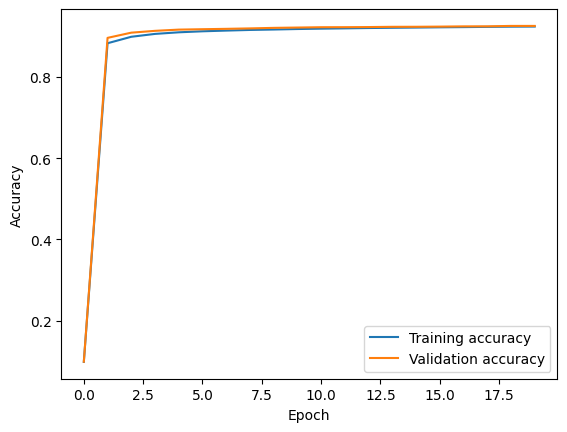

In [8]:
import matplotlib.pyplot as plt

plt.plot(train_acc_values, label='Training accuracy')
plt.plot(val_acc_values, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## Inference

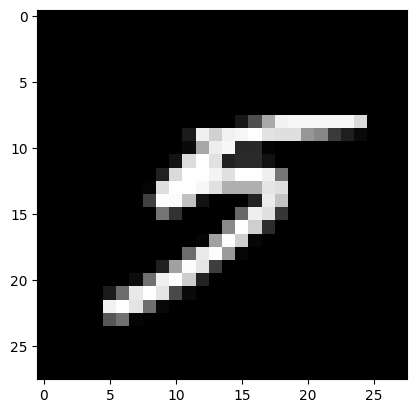

@main = primfn(A_1: handle, B_1: handle, compute_1: handle) -> ()
  attr = {"from_legacy_te_schedule": True, "global_symbol": "main", "tir.noalias": True}
  buffers = {A: Buffer(A_2: Pointer(float32), float32, [784], []),
             B: Buffer(B_2: Pointer(float32), float32, [7840], []),
             compute: Buffer(compute_2: Pointer(float32), float32, [10], [])}
  buffer_map = {A_1: A, B_1: B, compute_1: compute}
  preflattened_buffer_map = {A_1: A_3: Buffer(A_2, float32, [1, 784], []), B_1: B_3: Buffer(B_2, float32, [784, 10], []), compute_1: compute_3: Buffer(compute_2, float32, [1, 10], [])} {
  for (j.outer: int32, 0, 3) {
    for (j.inner.init: int32, 0, 4) {
      if @tir.likely((((j.outer*2) + floordiv(j.inner.init, 2)) < 5), dtype=bool) {
        compute[((j.outer*4) + j.inner.init)] = 0f32
      }
    }
    for (k.outer: int32, 0, 196) {
      for (j.inner: int32, 0, 4) {
        if @tir.likely((((j.outer*2) + floordiv(j.inner, 2)) < 5), dtype=bool) {
          let cse_var_

In [9]:
# visualize the data
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
 
# pick a random image from the test set
idx = np.random.randint(0, test_set[0].shape[0])
img_linear = test_set[0][idx]
# reshape the image into 28x28 array (original shape of the image)
img = img_linear.reshape(28, 28)
# plot the image
plt.imshow(img, cmap=cm.Greys_r)
plt.show()

# get predictions
img_linear = img_linear.reshape(1, 784)
test_X_val.copyfrom(img_linear)
test_y_val.copyfrom(convert_to_one_hot(test_set_y[idx:idx+1]))
_, _, _, y_pred = executor.run(
    feed_dict={X: test_X_val, y_: test_y_val, W1: W1_val, b1: b1_val})
print("Predicted digit:", y_pred.asnumpy().argmax(axis=1)[0])
print("Actual digit:", test_set_y[idx])